In [70]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
import collections
import matplotlib.patches as mpatches
import time

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

# Disable warnings
import warnings
warnings.filterwarnings("ignore")


In [71]:
# Carga del archivo

In [72]:
ruta_archivo = 'Desktop/Augusto/Datasets para pruebas/Temperaturas/city_temperature.csv'
df_temperatura = pd.read_csv(ruta_archivo)
df_temperatura

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...,...,...
2906322,North America,US,Additional Territories,San Juan Puerto Rico,7,27,2013,82.4
2906323,North America,US,Additional Territories,San Juan Puerto Rico,7,28,2013,81.6
2906324,North America,US,Additional Territories,San Juan Puerto Rico,7,29,2013,84.2
2906325,North America,US,Additional Territories,San Juan Puerto Rico,7,30,2013,83.8


In [73]:
# Tipos de datos presentes en el dataset

In [74]:
df_temperatura.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Region          object 
 1   Country         object 
 2   State           object 
 3   City            object 
 4   Month           int64  
 5   Day             int64  
 6   Year            int64  
 7   AvgTemperature  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 177.4+ MB


In [75]:
# Revisamos la existencia de valores nulos

In [76]:
df_temperatura.isnull().sum()

Region                  0
Country                 0
State             1450990
City                    0
Month                   0
Day                     0
Year                    0
AvgTemperature          0
dtype: int64

In [77]:
# Expresamos los valores nulos de State en proporciones

In [78]:
porcentaje_perdida = df_temperatura.isnull().mean()
porcentaje_perdida

Region            0.000000
Country           0.000000
State             0.499252
City              0.000000
Month             0.000000
Day               0.000000
Year              0.000000
AvgTemperature    0.000000
dtype: float64

In [79]:
# Casi un 50% del total de datos en la columna 'State' son nulos. Procedemos a descartarlos 

In [80]:
df_temperatura.drop('State', axis=1, inplace=True)
df_temperatura.head()

,Region,Country,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,Algiers,1,1,1995,64.2
1,Africa,Algeria,Algiers,1,2,1995,49.4
2,Africa,Algeria,Algiers,1,3,1995,48.8
3,Africa,Algeria,Algiers,1,4,1995,46.4
4,Africa,Algeria,Algiers,1,5,1995,47.9


In [81]:
# Creamos una nueva columna que exprese los grados en Celsius y no en Farenheit

In [82]:
df_temperatura['AvgTemperature_Celsius'] = ((df_temperatura['AvgTemperature'] - 32) * 5/9).round(0)
df_temperatura.head()

,Region,Country,City,Month,Day,Year,AvgTemperature,AvgTemperature_Celsius
0,Africa,Algeria,Algiers,1,1,1995,64.2,18.0
1,Africa,Algeria,Algiers,1,2,1995,49.4,10.0
2,Africa,Algeria,Algiers,1,3,1995,48.8,9.0
3,Africa,Algeria,Algiers,1,4,1995,46.4,8.0
4,Africa,Algeria,Algiers,1,5,1995,47.9,9.0


In [83]:
# Realizamos un conteo de las regiones presentes en la informacion

In [84]:
df_temperatura['Region'].value_counts()

North America                        1556681
Europe                                381990
Asia                                  316663
Africa                                251118
South/Central America & Carribean     219530
Middle East                           124749
Australia/South Pacific                55596
Name: Region, dtype: int64

In [85]:
# Lo mismo para ver los años comprendidos en el dataset

In [86]:
df_temperatura['Year'].value_counts()

2000    119682
1999    119355
2001    119355
2002    119355
2003    119140
1998    119082
1996    118951
1997    118656
2004    118645
1995    118616
2005    117895
2006    117647
2010    115627
2007    115428
2008    114908
2009    114247
2011    113740
2012    111993
2013    111021
2014    109018
2015    107498
2016    107237
2017    106946
2018    106698
2019    106337
2020     38810
201        351
200         89
Name: Year, dtype: int64

In [87]:
# Hay valores raros, 201 y 200 no tienen lugar como posibles años. Procedemos a eliminarlos
# Lo mismo sucede con dia, tiene que ser mayor a 0 ya que no existe
# Y con respecto a la temperatura, tambien eliminamos los valores por debajo de 70 Farenheit

In [88]:
df_temperatura = df_temperatura[df_temperatura['Day'] > 0]
df_temperatura = df_temperatura[df_temperatura['Year'] > 1994]
df_temperatura = df_temperatura[df_temperatura['Year'] < 2021]
df_temperatura = df_temperatura[df_temperatura['AvgTemperature'] > -70]

In [89]:
# Mediciones por cada region

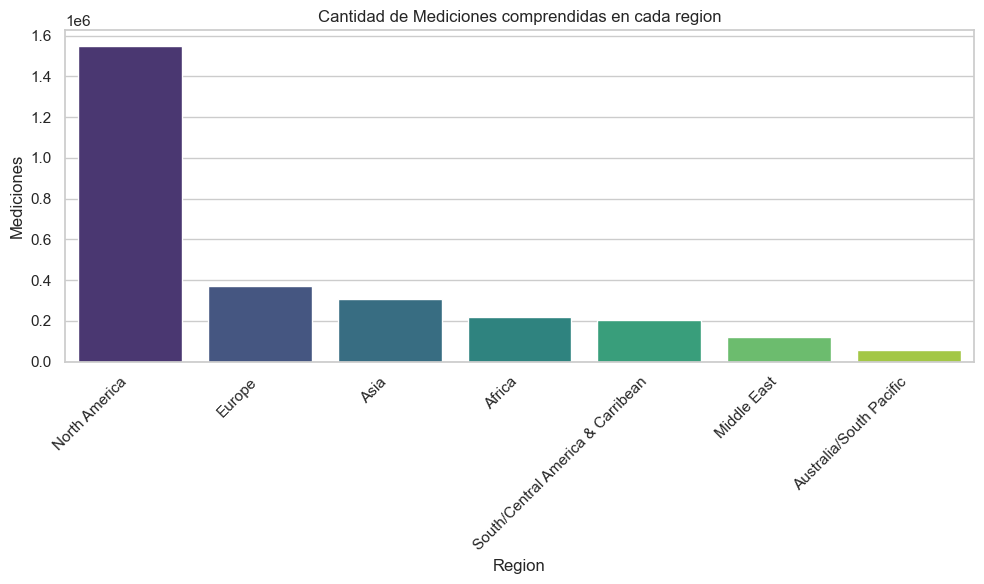

In [90]:
plt.figure(figsize=(10, 6))

sns.countplot(data=df_temperatura, x='Region', palette='viridis', order=df_temperatura['Region'].value_counts().index)

plt.xlabel('Region')
plt.ylabel('Mediciones')
plt.title('Cantidad de Mediciones comprendidas en cada region')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [91]:
#Procedemos a crear un gráfico de calor que muestre la concentración de medidas por país

In [92]:
counts_por_pais = df_temperatura['Country'].value_counts()

df_counts = pd.DataFrame({'Pais': counts_por_pais.index, 'Frecuencia': counts_por_pais.values})

fig = px.choropleth(df_counts, 
                    locations='Pais',
                    locationmode='country names',
                    color='Frecuencia',
                    title='Distribución de mediciones por país',
                    color_continuous_scale='Viridis')

fig.show()

In [93]:
top5_paises = df_temperatura['Country'].value_counts().head(5)
top5_paises

US           1450555
Canada         73965
China          46139
Australia      46002
India          36903
Name: Country, dtype: int64

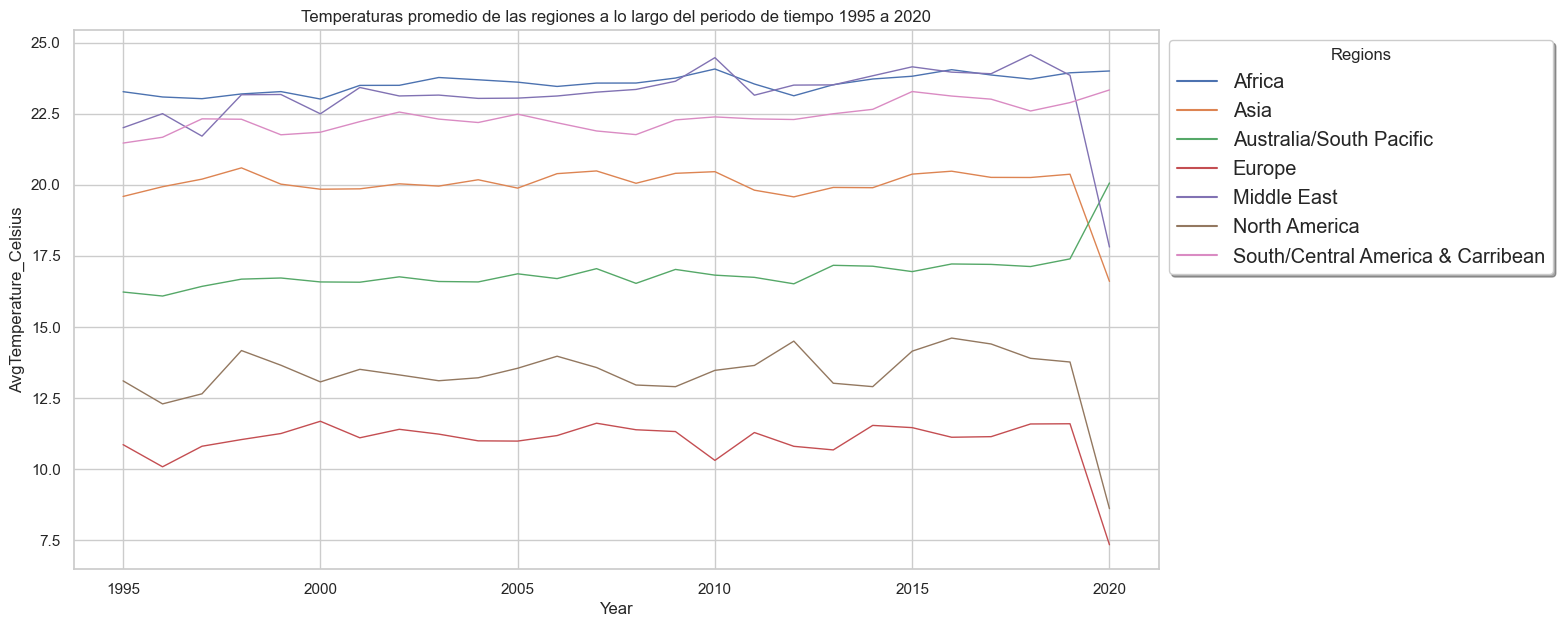

In [94]:
region = df_temperatura[['Region', 'Year', 'AvgTemperature_Celsius']].groupby(['Region', 'Year']).mean()
plt.figure(figsize = (14, 7))
plt.title('Temperaturas promedio de las regiones a lo largo del periodo de tiempo 1995 a 2020')
sns.lineplot(x = 'Year', y = 'AvgTemperature_Celsius', hue = 'Region', units = 'Region', markers = True, dashes = False, estimator = None, lw = 1, data = region)
plt.legend(bbox_to_anchor = (1, 1), shadow = True, fontsize = 'large', title = 'Regions')
plt.show()

In [95]:
import plotly.express as px

data1 = df_temperatura[['Country', 'Year', 'AvgTemperature_Celsius']].groupby(['Country', 'Year']).mean().reset_index()

data1 = data1.sort_values(by='Year')

fig = px.choropleth(data_frame=data1,
                    locations="Country",
                    locationmode='country names',
                    animation_frame="Year",
                    color='AvgTemperature_Celsius',
                    color_continuous_scale='Turbo',
                    title="Temperaturas promedio de los paises a lo largo del periodo de tiempo 1995 a 2020")

fig.update_layout(
    sliders=[dict(
        steps=[dict(label=str(year), method="animate", args=[{"frame": year, "mode": "immediate"}]) for year in data1['Year'].unique()],
        active=0,
    )]
)

fig.show()



In [96]:
# TOP 5 de paises con mayores registros de mediciones de temperaturas

In [97]:
df_temperatura['Country'].value_counts()
top5_paises = df_temperatura['Country'].value_counts().head(5)
top5_paises

US           1450555
Canada         73965
China          46139
Australia      46002
India          36903
Name: Country, dtype: int64

In [98]:
# Seleccionamos el caso particular de la Argentina para realizar estimaciones

In [99]:
df_argentina = df_temperatura[df_temperatura['Country'] == 'Argentina']
df_argentina

,Region,Country,City,Month,Day,Year,AvgTemperature,AvgTemperature_Celsius
1231460,South/Central America & Carribean,Argentina,Buenos Aires,1,1,1995,82.4,28.0
1231461,South/Central America & Carribean,Argentina,Buenos Aires,1,2,1995,75.1,24.0
1231462,South/Central America & Carribean,Argentina,Buenos Aires,1,3,1995,73.7,23.0
1231463,South/Central America & Carribean,Argentina,Buenos Aires,1,4,1995,77.1,25.0
1231464,South/Central America & Carribean,Argentina,Buenos Aires,1,5,1995,79.5,26.0
...,...,...,...,...,...,...,...,...
1240721,South/Central America & Carribean,Argentina,Buenos Aires,5,9,2020,61.3,16.0
1240722,South/Central America & Carribean,Argentina,Buenos Aires,5,10,2020,67.0,19.0
1240723,South/Central America & Carribean,Argentina,Buenos Aires,5,11,2020,62.4,17.0
1240724,South/Central America & Carribean,Argentina,Buenos Aires,5,12,2020,52.2,11.0


In [100]:
df_argentina.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9231 entries, 1231460 to 1240725
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Region                  9231 non-null   object 
 1   Country                 9231 non-null   object 
 2   City                    9231 non-null   object 
 3   Month                   9231 non-null   int64  
 4   Day                     9231 non-null   int64  
 5   Year                    9231 non-null   int64  
 6   AvgTemperature          9231 non-null   float64
 7   AvgTemperature_Celsius  9231 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 649.1+ KB


In [101]:
df_argentina['Year'].value_counts()

2012    366
2004    366
1996    366
1995    365
2010    365
1997    365
2017    365
2000    365
2014    365
2013    365
2005    365
2006    365
2011    365
2015    364
2008    364
2009    364
2007    364
2001    364
1999    364
2003    363
2016    363
2002    360
1998    360
2018    360
2019    359
2020    134
Name: Year, dtype: int64

In [102]:
# Grafico de temperatura promedio a lo largo de los años en Argentina, puntualmente en Buenos Aires.

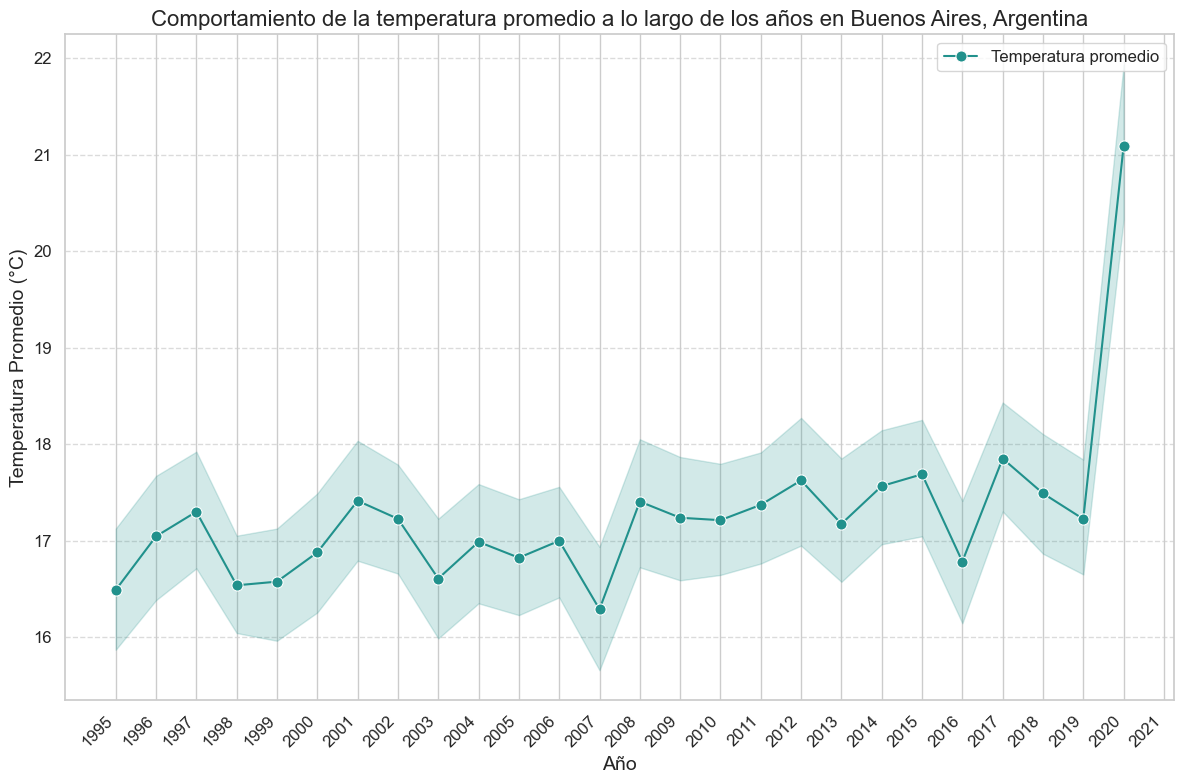

In [103]:
sns.set(style="whitegrid")

colores = sns.color_palette("viridis", n_colors=1)

plt.figure(figsize=(12, 8))
sns.lineplot(data=df_argentina, x='Year', y='AvgTemperature_Celsius', color=colores[0], marker='o', markersize=8, label='Temperatura promedio')

plt.title('Comportamiento de la temperatura promedio a lo largo de los años en Buenos Aires, Argentina', fontsize=16)
plt.xlabel('Año', fontsize=14)
plt.ylabel('Temperatura Promedio (°C)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(range(min(df_argentina['Year']), max(df_argentina['Year']) + 2, 1))

plt.tight_layout()

plt.show()

In [104]:
# Realizamos lo mismo pero apuntando ahora a ver la fluctuacion de la temperatura a lo largo de los meses

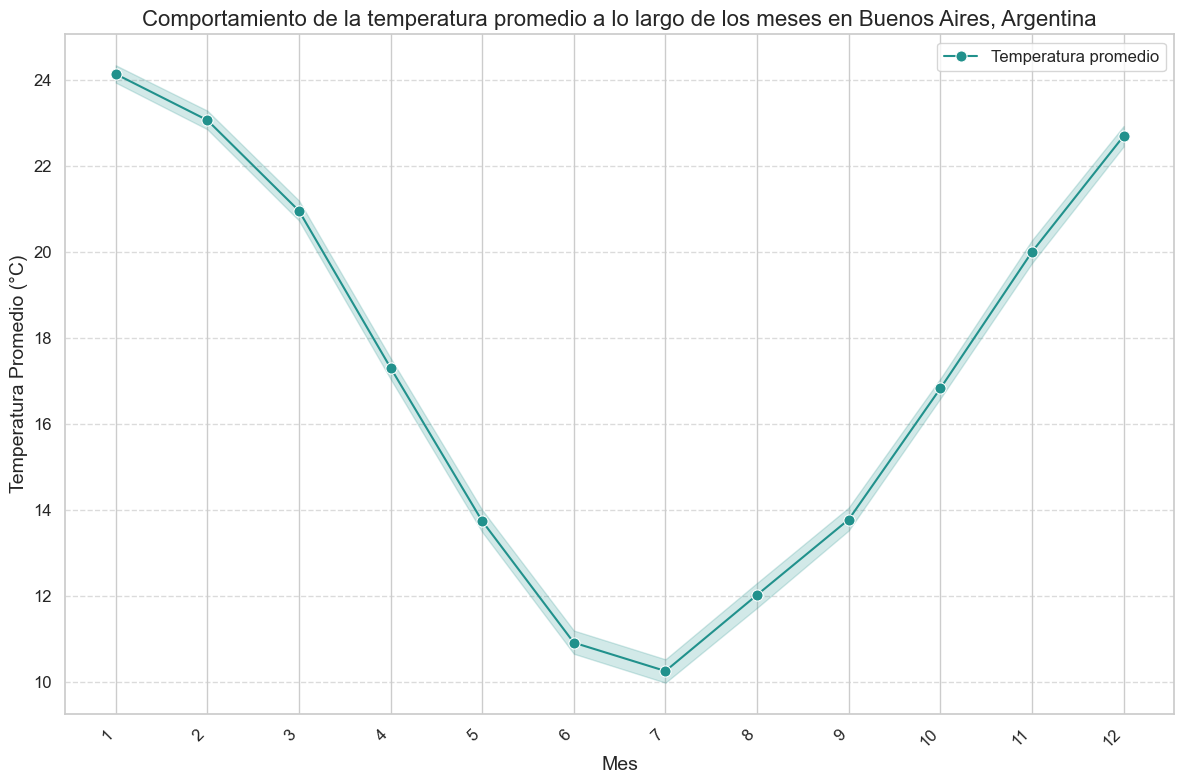

In [105]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_argentina, x='Month', y='AvgTemperature_Celsius', color=colores[0], marker='o', markersize=8, label='Temperatura promedio')

plt.title('Comportamiento de la temperatura promedio a lo largo de los meses en Buenos Aires, Argentina', fontsize=16)
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Temperatura Promedio (°C)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(range(1, 13, 1))

plt.tight_layout()

plt.show()

In [106]:
# Evaluamos la estacionariedad de la serie de tiempo con la prueba Dickey-Fuller 

In [107]:
result = adfuller(df_argentina['AvgTemperature_Celsius'])
print('Estadístico de la prueba Dickey-Fuller:', result[0])
print('P-valor:', result[1])


Estadístico de la prueba Dickey-Fuller: -5.82723898320292
P-valor: 4.0523899547297055e-07


In [108]:
# Los resultados sugieren que la serie temporal de temperaturas promedio en Argentina es estacionaria

In [109]:
# Creamos un modelo de regresion lineal para poder predecir valores futuros de la temperatura promedio

In [110]:
X = df_argentina[['Month', 'Day', 'Year']]
y = df_argentina['AvgTemperature_Celsius']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linear_model = LinearRegression()

linear_model.fit(X_train_scaled, y_train)

predictions = linear_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error (Regresión Lineal): {mse}')
print(f'R² (Regresión Lineal): {r2}')


Mean Squared Error (Regresión Lineal): 34.8571175272652
R² (Regresión Lineal): 0.04259448670882593


In [111]:
# Vemos que el R2 es de aproximadamente un 4%, lo cual sugiere que las variables comprendidas,
# ceteribus paribus resto de variables, no explican de manera correcta el comportamiento de la temperatura promedio.

In [112]:
# Aplicamos ahora una regresion de tipo polinomica para ver si obtenemos mejor resultado

In [113]:
degree = 2
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

poly_model.fit(X_train_scaled, y_train)

poly_predictions = poly_model.predict(X_test_scaled)

poly_mse = mean_squared_error(y_test, poly_predictions)
poly_r2 = r2_score(y_test, poly_predictions)

print(f'Mean Squared Error (Regresión Polinómica): {poly_mse}')
print(f'R² (Regresión Polinómica): {poly_r2}')


Mean Squared Error (Regresión Polinómica): 14.742373171045216
R² (Regresión Polinómica): 0.595077552183875


In [114]:
# Mejoro notablemente el comportamiento del R2 con respecto a la regresion lineal
# Sin embargo, aplicare "Grid Search" para encontrar los mejores parametros para la regresion polinomica

In [115]:
param_grid = {'polynomialfeatures__degree': [2, 3, 4, 5]}

poly_model = make_pipeline(PolynomialFeatures(), Ridge())

grid_search = GridSearchCV(poly_model, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train_scaled, y_train)

print("Mejores parámetros:", grid_search.best_params_)
print("Mean Squared Error en conjunto de validación:", -grid_search.best_score_)

best_poly_model = grid_search.best_estimator_
poly_predictions = best_poly_model.predict(X_test_scaled)
poly_mse = mean_squared_error(y_test, poly_predictions)
poly_r2 = r2_score(y_test, poly_predictions)

print(f'Mean Squared Error en conjunto de prueba: {poly_mse}')
print(f'R² en conjunto de prueba: {poly_r2}')

Mejores parámetros: {'polynomialfeatures__degree': 5}
Mean Squared Error en conjunto de validación: 11.813425118224405
Mean Squared Error en conjunto de prueba: 12.617285532984926
R² en conjunto de prueba: 0.6534464238874633


In [116]:
# Aplicamos entonces el grado 5 para la regresion polinomica. Tambien se observa que disminuyo el MSE

In [117]:
degree = 5
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

poly_model.fit(X_train_scaled, y_train)

poly_predictions = poly_model.predict(X_test_scaled)

poly_mse = mean_squared_error(y_test, poly_predictions)
poly_r2 = r2_score(y_test, poly_predictions)

print(f'Mean Squared Error (Regresión Polinómica): {poly_mse}')
print(f'R² (Regresión Polinómica): {poly_r2}')

Mean Squared Error (Regresión Polinómica): 12.617413927910093
R² (Regresión Polinómica): 0.653442897319062


In [118]:
# Nos encontramos asi con un R2 de un 65% aproximadamente, lo cual demuestra que a traves de la regresion polinomica
# Las variables comprendidas, ceteribus paribus el resto de variables, explica de manera aceptable el comportamiento
# De la temperatura promedio en celcius de la ciudad de Buenos Aires, Argentina.